# ERA5/ibtracs data exploration
Make sure you are using the conda environment defined in data-env.yaml
```
conda env create -f data-env.yaml
```
Then chose that conda env for this notebook kernel before executing

In [2]:
import boto3
import netCDF4
import os
import boto3
import sagemaker
import xarray as xr

sess = sagemaker.Session()
bucket = sess.default_bucket()                    # Set a default S3 bucket
print(f"Using s3 bucket: {bucket}")
DATA_DIR="/root/data_downloads"
print(f"Using local data path: {DATA_DIR}")

Using s3 bucket: sagemaker-us-west-2-014690315417
Using local data path: /root/data_downloads


In [3]:
# Create a Boto3 S3 client
#IBTrACS.since1980.v04r00.nc
# s3key = "data/ibtracs/IBTrACS.ALL.v04r00.nc"
s3key = "data/ibtracs/IBTrACS.since1980.v04r00.nc"
ibtracs_dir = f"{DATA_DIR}/ibtracs"
%alias mkdatadir mkdir -p %l
%mkdatadir $ibtracs_dir
# dest = "/data_downloads/ibtracs/IBTrACS.ALL.v04r00.nc"
ibtracs_dest = f"{ibtracs_dir}/IBTrACS.since1980.v04r00.nc"
if os.path.exists(ibtracs_dest):
    print(f"{ibtracs_dest} already downloaded")
else:
    s3 = boto3.client('s3')
    s3.download_file(bucket, s3key, ibtracs_dest)
    print(f"downloaded {ibtracs_dest}")
# s3.download_file(bucket, s3key, dest)
# Open the downloaded NetCDF file


/root/data_downloads/ibtracs/IBTrACS.since1980.v04r00.nc already downloaded


In [51]:
ibtracs = netCDF4.Dataset(ibtracs_dest)


In [5]:
for dim_name, dim in ibtracs.dimensions.items():
    print(f"Dimension: {dim_name}, {dim}")
print()
for var_name, variable in ibtracs.variables.items():
    if "bom_roci" in var_name or "usa_sshs" in var_name:
        print(f"Variable: {var_name}, dim: {variable.dimensions}")
        print(variable)  # Access the values as a numpy array
        print()
    if "time" in var_name:
        print(f"Variable: {var_name}")
        print(variable)  # Access the values as a numpy array
        print()
    # print()

Dimension: storm, <class 'netCDF4._netCDF4.Dimension'>: name = 'storm', size = 4687
Dimension: charsn, <class 'netCDF4._netCDF4.Dimension'>: name = 'charsn', size = 13
Dimension: date_time, <class 'netCDF4._netCDF4.Dimension'>: name = 'date_time', size = 360
Dimension: char2, <class 'netCDF4._netCDF4.Dimension'>: name = 'char2', size = 2
Dimension: char128, <class 'netCDF4._netCDF4.Dimension'>: name = 'char128', size = 128
Dimension: niso, <class 'netCDF4._netCDF4.Dimension'>: name = 'niso', size = 19
Dimension: char14, <class 'netCDF4._netCDF4.Dimension'>: name = 'char14', size = 14
Dimension: char32, <class 'netCDF4._netCDF4.Dimension'>: name = 'char32', size = 32
Dimension: char1, <class 'netCDF4._netCDF4.Dimension'>: name = 'char1', size = 1
Dimension: quadrant, <class 'netCDF4._netCDF4.Dimension'>: name = 'quadrant', size = 4
Dimension: char6, <class 'netCDF4._netCDF4.Dimension'>: name = 'char6', size = 6
Dimension: char10, <class 'netCDF4._netCDF4.Dimension'>: name = 'char10', si

In [6]:
# print(dataset)
# # Get the dimension names and sizes
# dimension_names = dataset.dimensions.keys()

# # Print dimension names and sizes
# for dim_name in dimension_names:
#     dimension = dataset.dimensions[dim_name]
#     print(f"Dimension: {dim_name}")
#     print(f"Size: {dimension.size}")
#     print()
print(ibtracs.dimensions["storm"])
print(ibtracs.dimensions["date_time"])
print(ibtracs.dimensions["niso"])

sshs_0 = ibtracs.variables["usa_sshs"][0][:]
sshs_0_times = ibtracs.variables["iso_time"][0][:]
# print(sshs_0)
# # print(sshs_0_times)
# for time in sshs_0_times:
#     print(time.tobytes().decode("utf-8"))
    
# will want to find corresponding times for 

# hourly data on pressure levels
# https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=form

# hourly data on single levels
# https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form

<class 'netCDF4._netCDF4.Dimension'>: name = 'storm', size = 4687
<class 'netCDF4._netCDF4.Dimension'>: name = 'date_time', size = 360
<class 'netCDF4._netCDF4.Dimension'>: name = 'niso', size = 19


# ECMWF ERA5 example download

## Single Level variables

In [7]:
import cdsapi

era5_single_level_dir=f"{DATA_DIR}/era5/single"
%alias mkdatadir mkdir -p %l
%mkdatadir $era5_single_level_dir

c = cdsapi.Client()
year = "1980"
month = "01"
day = "01"
single_dest_filename = f'{era5_single_level_dir}/{year}-{month}-{day}.nc'
if os.path.exists(single_dest_filename):
    print(f"{single_dest_filename} already exists. Skipping...")
else:
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'year': year,
            'month': month,
            'day': day,
            'time': [
                '00:00', '03:00', '06:00',
                '09:00', '12:00', '15:00',
                '18:00', '21:00',
            ],
            'variable': [
                '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
                '2m_temperature', 'convective_available_potential_energy', 'mean_sea_level_pressure',
                'mean_total_precipitation_rate', 'sea_surface_temperature', 'surface_pressure',
                'total_column_water_vapour',
            ],
            # 'variable': [
            #     '2m_dewpoint_temperature', '2m_temperature', 'mean_sea_level_pressure',
            #     'mean_total_precipitation_rate', 'skin_temperature', 'surface_pressure',
            #     'total_column_water_vapour',
            # ],
        },
        single_dest_filename)

/root/data_downloads/era5/single/1980-01-01.nc already exists. Skipping...


## Pressure-level Variables

In [8]:
era5_pressure_level_dir=f"{DATA_DIR}/era5/multi"
%alias mkdatadir mkdir -p %l
%mkdatadir $era5_pressure_level_dir
multi_dest_filename = f'{era5_pressure_level_dir}/{year}-{month}-{day}.nc'
if os.path.exists(multi_dest_filename):
    print(f"{multi_dest_filename} already exists. Skipping...")
else:
    c.retrieve(
        'reanalysis-era5-pressure-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'pressure_level': [
                '500', '850', '1000',
            ],
            'variable': [
                'geopotential', 
                'temperature', 
                'u_component_of_wind',
                'v_component_of_wind', 
                'vorticity',
            ],
            'time': [
                '00:00', '03:00', '06:00',
                '09:00', '12:00', '15:00',
                '18:00', '21:00',
            ],
            'day': '01',
            'month': '01',
            'year': '1980',
        },
        multi_dest_filename)

/root/data_downloads/era5/multi/1980-01-01.nc already exists. Skipping...


# ERA5, ibtracs Fusion

In [9]:
era5_single_file = f'{era5_single_level_dir}/{year}-{month}-{day}.nc'
era5_multi_file = f'{era5_pressure_level_dir}/{year}-{month}-{day}.nc'

era5_single = netCDF4.Dataset(era5_single_file)
era5_multi = netCDF4.Dataset(era5_multi_file)

for var_name, var in era5_single.dimensions.items():
    print(f"Single-level Dimension: {var_name}, size={var.size}")
    
print()

for var_name, var in era5_single.variables.items():
    print(f"Single-level Variable: {var_name}, dim: {var.dimensions}")
print()

for var_name, var in era5_multi.dimensions.items():
    print(f"Multi-level Dimension: {var_name}, size={var.size}")
    
print()
# multi_variable_names = era5_multi.variables.keys()
for var_name, var in era5_multi.variables.items():
    print(f"Multi-level Variable: {var_name}, dim: {var.dimensions}")



Single-level Dimension: longitude, size=1440
Single-level Dimension: latitude, size=721
Single-level Dimension: time, size=8

Single-level Variable: longitude, dim: ('longitude',)
Single-level Variable: latitude, dim: ('latitude',)
Single-level Variable: time, dim: ('time',)
Single-level Variable: u10, dim: ('time', 'latitude', 'longitude')
Single-level Variable: v10, dim: ('time', 'latitude', 'longitude')
Single-level Variable: d2m, dim: ('time', 'latitude', 'longitude')
Single-level Variable: t2m, dim: ('time', 'latitude', 'longitude')
Single-level Variable: cape, dim: ('time', 'latitude', 'longitude')
Single-level Variable: msl, dim: ('time', 'latitude', 'longitude')
Single-level Variable: mtpr, dim: ('time', 'latitude', 'longitude')
Single-level Variable: sst, dim: ('time', 'latitude', 'longitude')
Single-level Variable: sp, dim: ('time', 'latitude', 'longitude')
Single-level Variable: tcwv, dim: ('time', 'latitude', 'longitude')

Multi-level Dimension: longitude, size=1440
Multi-l

In [31]:
# Generate radius for a single TC
import pandas as pd
import numpy as np

# sshs_0 = dataset.variables["usa_sshs"][0][:]
# sshs_0_times = dataset.variables["iso_time"][0][:]
# print(sshs_0)
# # print(sshs_0_times)
# for time in sshs_0_times:
#     print(time.tobytes().decode("utf-8"))
def ibtracs_time_to_str(ibtracs_time):
    return ibtracs_time.tobytes().decode("utf-8")


masked_lat = ibtracs.variables["lat"][:]
masked_lat = np.ma.masked_array(masked_lat, mask=(masked_lat == ibtracs.variables["lat"]._FillValue), fill_value=None)
masked_lon = ibtracs.variables["lon"][:]
masked_lon = np.ma.masked_array(masked_lon, mask=(masked_lon == ibtracs.variables["lon"]._FillValue), fill_value=None)
masked_roci = ibtracs.variables["bom_roci"][:]
masked_roci = np.ma.masked_array(masked_roci, mask=(masked_roci == ibtracs.variables["bom_roci"]._FillValue), fill_value=None)
max_roci = np.argmax(ibtracs.variables["bom_roci"])
max_roci = np.unravel_index(max_roci, ibtracs.variables["bom_roci"].shape)
# print("roci max", np.max(ibtracs.variables["bom_roci"]), max_roci)

# lat_dist = np.empty((era5_single.dimensions["latitude"].size, ibtracs_dataset.dimensions["storm"].size, ibtracs_dataset.dimensions["date_time"].size))


# generate a mask per storm
def haversine_distance(lat, lon, lat_center, lon_center):
    """
    returns matrix of dim (lat,lon) with distance in nautical miles
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat, lon, lat_center, lon_center])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    print(dlon.shape, dlat.shape)
    a = np.sin(dlat[:,None] / 2) ** 2 + np.cos(lat1[:,None]) * np.cos(lat2) * np.sin(dlon[None,:] / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of the Earth in kilometers

    # Calculate the distance in 
    distance = c * r
    # 1.852 km per nautical mile
    return distance / 1.852

# (2403, 37)
storm_id = 2403
timestep = 5

distances = haversine_distance(era5_single.variables["latitude"], era5_single.variables["longitude"], masked_lat[storm_id,timestep], masked_lon[storm_id,timestep])

# print(distances.shape) 
tc_label = np.where(distances <= masked_roci[storm_id,timestep], 1, 0)
# print(np.max(tc_label))
# print(tc_label)
# print(distances)

minlat = int(masked_lat[storm_id, timestep] - 2)
maxlat = int(masked_lat[storm_id, timestep] + 2)
minlon = int(masked_lon[storm_id, timestep] - 2)
maxlon = int(masked_lon[storm_id, timestep] + 2)

data_xr = xr.DataArray(tc_label, coords={
    'lat': era5_single.variables["latitude"][:], 
    'lon': era5_single.variables["longitude"][:]}, 
    dims=('lat', 'lon'), 
    attrs={'units': 'Mask'}
).sel(lat=slice(maxlat, minlat), lon=slice(minlon,maxlon))
print(data_xr)



70.7 -68.5
90.0 -90.0
<class 'netCDF4._netCDF4.Dimension'>: name = 'storm', size = 4687 <class 'netCDF4._netCDF4.Dimension'>: name = 'date_time', size = 360
(1440,) (721,)
<xarray.DataArray (lat: 17, lon: 17)>
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0,

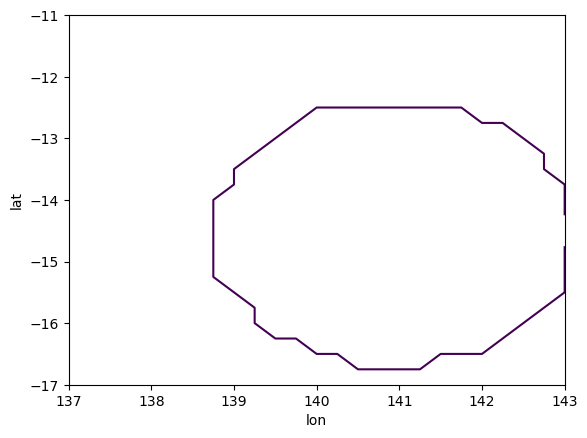

In [50]:
# !apt-get install gcc
# !pip install cartopy

import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmaps

import geocat.datafiles as gdf
import geocat.viz as gv

minlat = int(masked_lat[storm_id, timestep] - 3)
maxlat = int(masked_lat[storm_id, timestep] + 3)
minlon = int(masked_lon[storm_id, timestep] - 3)
maxlon = int(masked_lon[storm_id, timestep] + 3)

data_xr = xr.DataArray(tc_label, coords={
    'lat': era5_single.variables["latitude"][:], 
    'lon': era5_single.variables["longitude"][:]}, 
    dims=('lat', 'lon'), 
    attrs={'units': 'Mask'}
).sel(lat=slice(maxlat, minlat), lon=slice(minlon,maxlon))
# plt.figure(figsize=(10, 6))

# ibtracs_xr["usa_sshs"][storm_id, timestep].plot.scatter()
data_xr.plot.contour(levels=[0,1])
# ibtracs_xr["usa_sshs"].plot.scatter(x="lat",y="lon")


## ibtracs Saffir Simpson

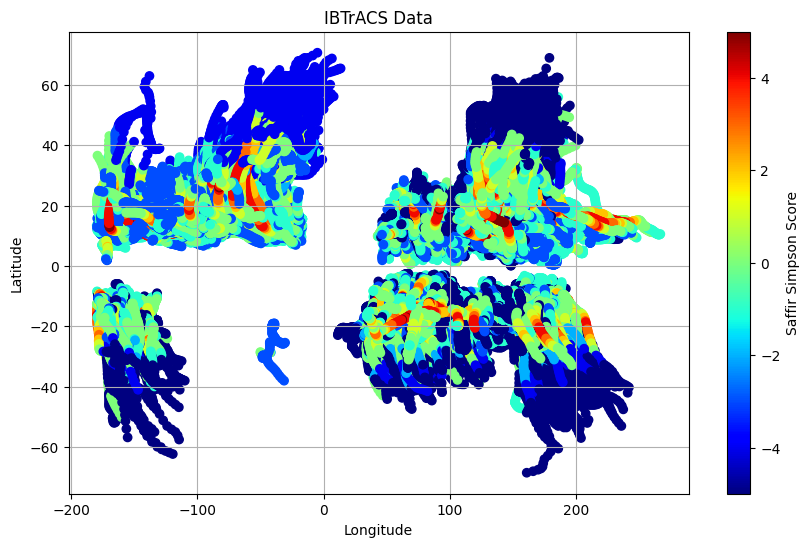

In [28]:
# !pip3 install https://github.com/matplotlib/basemap/archive/master.zip
import mpl_toolkits
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
# Extract the required variables
lon = ibtracs.variables["lon"][:]
lat = ibtracs.variables["lat"][:]
intensity = ibtracs.variables["usa_sshs"][:]

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, c=intensity, cmap="jet")
plt.colorbar(label="Saffir Simpson Score")
plt.title("IBTrACS Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()
